# Ensemble
`06_ensemble.ipynb`

- 정형 데이터 (Structured Data) 기준으로는 가장 뛰어난 상과를 내는 알고리즘 -> 앙상블 학습
- 대부분의 앙상블 학습 -> 트리 기반

## Random Forest
- 결정트리를 랜덤하게 만들어 트리의 숲을 만듦
- 각 결정트리의 예측을 종합해 최종 예측을 만듦
- 과대적합(overfitting)에 안전!

### 데이터 분할
- 데이터가 1000개면, 각 트리마다 1000개 데이터를 복원추출함. 이때 중복을 허용 (우연히 같은데이터만 1000개 가능)
- 노드 분할시, 분류 / 회귀의 특성 선택방식이 다름(분류: 개수를 루트함, 회귀: 특성을 다 씀)
- 기본값 100개의 트리를 만들어서
    - 분류: 다수결 투표
    - 회귀: 100개의 평균

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('./wine.csv')
X = wine[['alcohol', 'sugar', 'pH']]
y = wine['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# 교차검증(5 fold)
scores = cross_validate(rf, X_train, y_train, return_train_score=True, n_jobs=-1)

# 결정트리가 max_depth 튜닝이 없으면 Overfitting 됨 
#       훈련셋(일부)                        검증셋(훈련셋의 일부)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

# 진짜 학습 시키기
rf.fit(X_train, y_train)
# 트리(100개)들의 특성별 중요도 수치화

'''
이전 단일트리 특성 중요도: [0.12345626 0.86862934 0.0079144 ]
랜덤 포레스트 특성 중요도: [0.23167441 0.50039841 0.26792718]

노드마다 랜덤하게 특성들을 뽑아서 사용 -> 다양한 특성들이 훈련에서 기준으로 쓰임
-> 특정 특성에 과도하게 집중 방지 -> 다양한 특성이 훈련에 쓰일 기회를 받음 -> Overfitting을 줄이고 일반화 성능 높임
'''
print(rf.feature_importances_)

0.9973541965122431 0.8905151032797809
[0.23167441 0.50039841 0.26792718]


In [ ]:
# OOB(Out Of Bag) 샘플. -> 쓰지않은 샘플 존재 -> 남은 데이터들을 모아서 만든 샘플 (훈련에 참여 안한 샘플)
# OOB샘플로 점수 -> 마치 검증샘플 같은 역할
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train), rf.oob_score_)

0.996921300750433 0.8934000384837406


In [14]:
# 랜덤 포레스트의 하이퍼 파라미터 튜닝

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


params = {
    # Decision Tree 의 HP
    'max_depth': randint(3, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    # Random Forest 의 HP
    'max_features': ['sqrt', 'log2', None],  # 노드별 분할시 고려할 특성 수 (None->모든 특성 고려)
    'n_estimators': randint(50, 300)  # 트리 개수
}

rs = RandomizedSearchCV(
    rf,
    params,
    n_iter=100,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....002731D787CE0>, 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': <scipy.stats....002731D763F00>, 'min_samples_split': <scipy.stats....002731D76AC30>, ...}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [16]:
print('최적 파라미터', rs.best_params_)
print('최고 교차검증 점수', rs.best_score_)
print('테스트 스코어', rs.score(X_test, y_test))
# 최적 모델 인스턴스
best_rf = rs.best_estimator_
print('특성 중요도', best_rf.feature_importances_)

최적 파라미터 {'max_depth': 33, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 116}
최고 교차검증 점수 0.8899389205597098
테스트 스코어 0.8876923076923077
특성 중요도 [0.23112023 0.50010717 0.26877259]


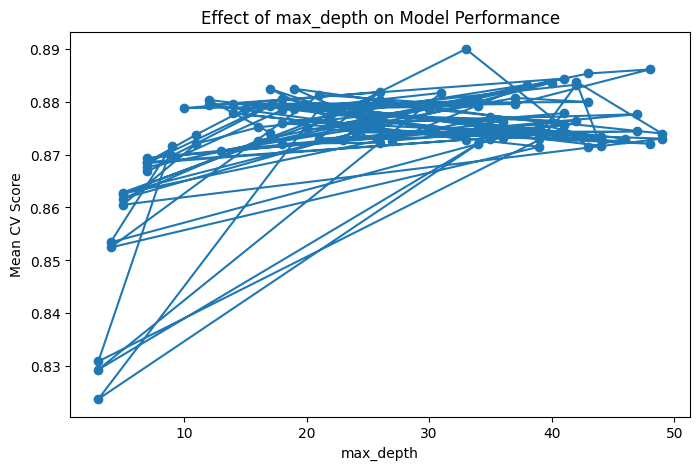

In [15]:
import matplotlib.pyplot as plt

results = pd.DataFrame(rs.cv_results_)

# max_depth vs mean_test_score
plt.figure(figsize=(8, 5))
plt.plot(results['param_max_depth'], results['mean_test_score'], marker='o')
plt.xlabel("max_depth")
plt.ylabel("Mean CV Score")
plt.title("Effect of max_depth on Model Performance")
plt.show()


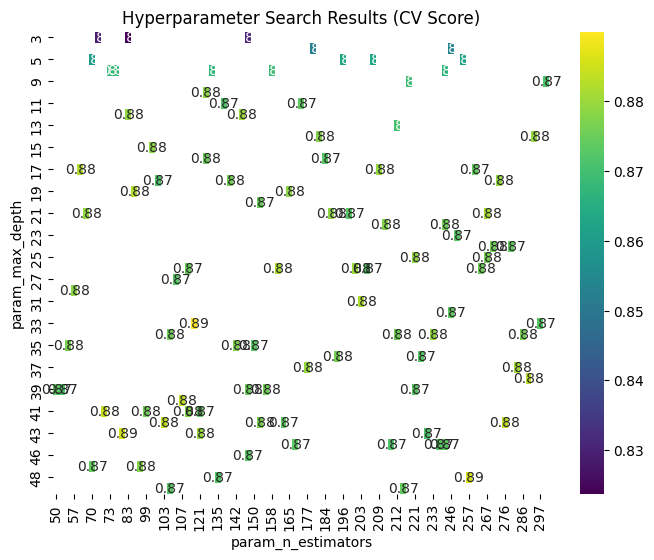

In [17]:
import seaborn as sns

pivot_table = results.pivot_table(values='mean_test_score',
                                  index='param_max_depth',
                                  columns='param_n_estimators')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title("Hyperparameter Search Results (CV Score)")
plt.show()


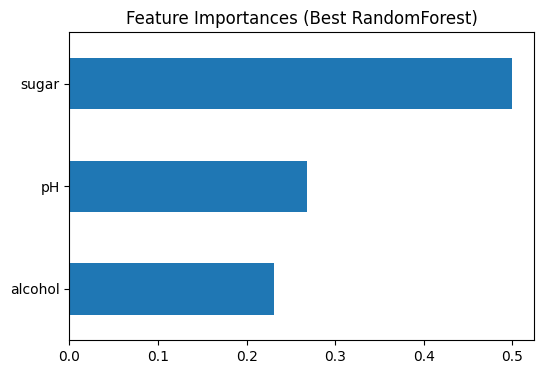

In [18]:
best_rf = rs.best_estimator_
importances = pd.Series(best_rf.feature_importances_, index=X.columns)

plt.figure(figsize=(6,4))
importances.sort_values().plot(kind='barh')
plt.title("Feature Importances (Best RandomForest)")
plt.show()


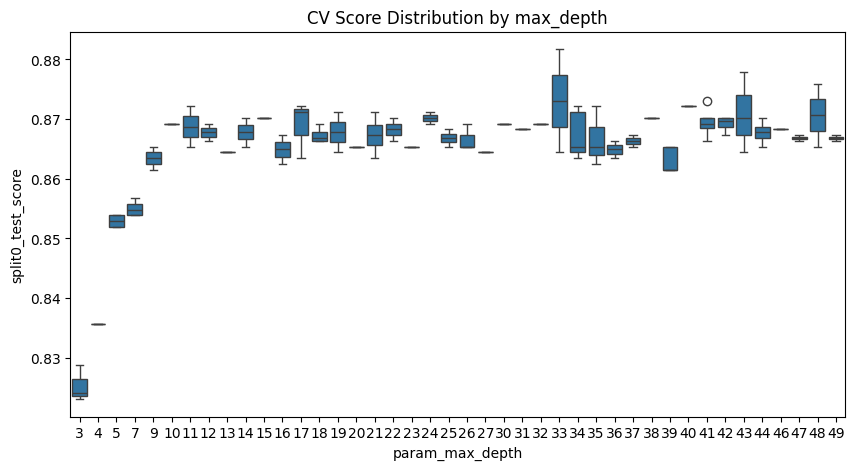

In [19]:
# 교차검증 결과 분포
plt.figure(figsize=(10,5))
sns.boxplot(x='param_max_depth', y='split0_test_score', data=results)
plt.title("CV Score Distribution by max_depth")
plt.show()
